In [1]:
from render import Renderer
from models_animated import SDFModule
from utils import *
import torch
import torch.nn as nn

def main():
    vertices = torch.zeros((3000000, 3)).cuda()
    normals = torch.zeros((3000000, 3)).cuda()
    faces = torch.empty((3000000, 3), dtype=torch.int32).cuda()

    frame_num = torch.randint(0, 3, (1,)).item()
    # frame_num = 1
    print(f"Frame: {frame_num}")
    
    if frame_num == 0:
        name = f'data/Anim_1/{frame_num}.obj'
    else:
        name = f'data/Anim_1/{frame_num}.ply'

    # Define renderer
    renderer = Renderer(num_views=10, res=512, fname=name)
    target_images = renderer.target_imgs

    # Define model
    module = SDFModule(
        cfg=Namespace(
            dim=4, out_dim=1, hidden_size=512, n_blocks=4, z_dim=1, const=60.0
        )
    ).cuda()

    # Load weights
    state_dict = torch.load("logs/21_Animated/best.ckpt")
    # state_dict = torch.load("logs/20_Animated/failed_model_2.pth")
    new_dict = {}
    for key in state_dict.keys():
        new_dict[key[13:]] = state_dict[key]

    module.synthesis_nw.load_state_dict(new_dict)

    with torch.no_grad():
        vertices_np, faces_np = module.get_zero_points(t=frame_num)
        v = vertices_np.shape[0]
        f = faces_np.shape[0]
        vertices.data[:v] = torch.from_numpy(vertices_np)
        faces.data[:f] = torch.from_numpy(np.ascontiguousarray(faces_np))

        face_normals = compute_face_normals(vertices[:v], faces[:f])
        vertex_normals = compute_vertex_normals(vertices[:v], faces[:f], face_normals)
    est_imgs = renderer.render(vertices[:v], faces[:f], vertex_normals)

    return target_images, est_imgs

/opt/conda/envs/geometry/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/geometry/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py:48: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning_lite.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
Global seed set to 42


In [7]:
target_images, est_imgs = main()

Frame: 2


In [8]:
import matplotlib.pyplot as plt

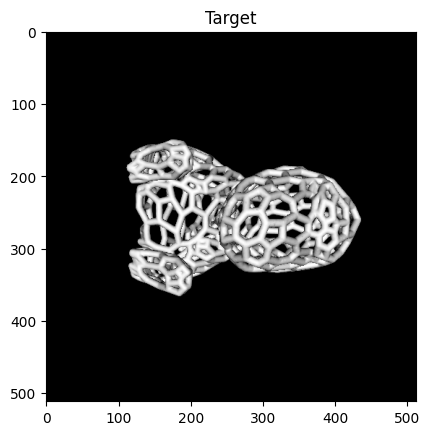

In [9]:
plt.title("Target")
plt.imshow(
    target_images[-1].permute(2, 0, 1).clamp(0, 1).cpu().numpy().transpose(1, 2, 0),
    cmap="gray",
)

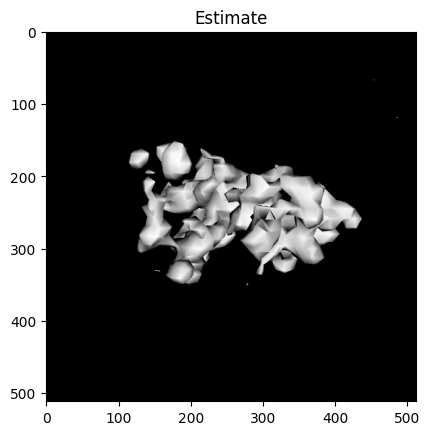

In [10]:
plt.title("Estimate")
plt.imshow(est_imgs[-1].permute(2, 0, 1).clamp(0, 1).cpu().numpy().transpose(1, 2, 0), cmap="gray")